In [1]:
import sys
import os
changed_dir = False
if(not changed_dir):
    os.chdir(os.path.join(os.getcwd(), "../"))
    sys.path.append(os.getcwd())
    print(os.getcwd())
    changed_dir = True

/home/anupa/Netmon/NetMon-query-planner/gurobi


In [2]:
'''
Goal: Find best overlay for a given input
'''
import numpy as np
import random
import math
import time
import ipdb
import traceback

from input import dc_topology, eps0
from main import solve
from config import common_config
from common import setup_logging, Namespace


def flatten(l):
    ret = []
    for x in l:
        if(isinstance(x, list)):
            ret.extend(flatten(x))
        else:
            ret.append(x)
    return ret


INP = dc_topology(hosts_per_tors=8, num_queries=4*40, tenant=True,
                  overlay='tor', refine=True,
                  queries_per_tenant=40)
x0 = np.array(flatten(INP.overlay))

ELEMENTS_PER_PART = 8
NITER = 500

OPT = 2105
SPECTRALA = 2134
TENANT = 2135
TOR = 2295
RANDOM = 2315

TSTART = (RANDOM - OPT) / 2
TSTOP = 5

common_config.solver = 'Netmon'
common_config.vertical_partition = True
common_config.prog_dir = None
setup_logging(common_config)


class Anneal():

    def __init__(self, func, x0, Tstart, Tstop, take_step,
                 alpha=0.995, niter=100, callback=None):
        self.func = func
        self.x0 = x0
        self.Tstart = Tstart
        self.Tstop = Tstop
        self.niter = niter
        self.take_step = take_step
        self.alpha = alpha
        self.callback = callback

    def accept_reject(self, energy_new, energy_old):
        if(energy_new < energy_old):
            return True
        else:
            # import ipdb; ipdb.set_trace()
            # print("DeltaE: {}".format(energy_new - energy_old))
            # print("Exp: {}".format( -(energy_new - energy_old)/self.T ))
            # print("Prob: {}".format(math.exp(
            #     -(energy_new - energy_old)/self.T)))
            return random.random() <= math.exp(
                -(energy_new - energy_old)/self.T
            )

    def anneal(self):

        x = self.x0
        f = self.func(x)
        if(getattr(self, 'callback', None)):
            self.callback(x, f, True)

        self.iteration = 0
        self.T = self.Tstart
        while self.T >= self.Tstop and self.iteration < self.niter:

            x_after_step = np.copy(x)
            x_after_step = self.take_step(x_after_step)
            f_after_step = self.func(x_after_step)
            accept = self.accept_reject(f_after_step, f)

            if(getattr(self, 'callback', None)):
                val = self.callback(x_after_step, f_after_step, accept)
                if(val):
                    break

            if(accept):
                f = f_after_step
                x = x_after_step

            self.T *= self.alpha
            self.iteration += 1


class TakeStep():
    def __init__(self, stepsize=1):
        self.stepsize = stepsize

    def __call__(self, perm):
        n = len(perm)
        l = random.randint(2, int((n - 1) * self.stepsize))
        i = random.randint(0, n - l)
        perm = perm.tolist()
        perm[i: (i + l)] = reversed(perm[i: (i + l)])
        return np.array(perm)


class Callback():
    def __init__(self):
        self.data = []
        self.best = Namespace(x=x0, f=func(x0))

    def __call__(self, x, f, accept):
        print(x, f, accept)
        self.data.append(tuple((x, f, accept)))
        if(accept):
            if(f < self.best.f):
                self.best.x = x
                self.best.f = f

        if(abs(f - OPT) < TSTOP):
            return True


# No side effects
def get_overlay_from_perm(perm):
    n = len(perm)
    split_parts = math.floor(n/ELEMENTS_PER_PART)
    covered_elements = split_parts * ELEMENTS_PER_PART
    splits = np.split(
        perm[:covered_elements],
        split_parts)
    splits = [x.astype(int).tolist() for x in splits]
    splits[-1].extend(perm[covered_elements:].astype(int))
    return splits


def func(perm):
    INP.overlay = get_overlay_from_perm(perm)
    # start = time.time()
    (ns, res) = solve(INP)
    # print(ns, res)
    # end = time.time()
    return res  # ((res + 10000) * ns)/1000

Function: dc_topology took 0.0009417533874511719 seconds
Function: dc_topology took 0.0007879734039306641 seconds
Function: dc_topology took 0.0034821033477783203 seconds
Function: dc_topology took 0.2712855339050293 seconds
Function: dc_topology took 0.0009930133819580078 seconds
Function: dc_topology took 0.0014302730560302734 seconds
Function: dc_topology took 0.12213492393493652 seconds
Buliding spectral overlay with 983 devices
Function: get_spectral_overlay took 0.41187477111816406 seconds
Function: dc_topology took 0.41895389556884766 seconds
Function: dc_topology took 0.6044538021087646 seconds
Function: dc_topology took 0.0014581680297851562 seconds


In [3]:
cb = Callback()
ts = TakeStep()
simanneal = Anneal(func, x0,
                   take_step=ts, callback=cb, Tstart=TSTART, Tstop=TSTOP,
                   niter=NITER)
simanneal.anneal()
print(cb.best)

Using license file /home/anupa/gurobi.lic
Academic license - for non-commercial use only
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38] 2255.2809329759025 True
[ 0  1  3  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38] 2265.2809329759025 True
[ 0  1  3  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 38 37 36 35 34 33 32 31 30 29 28 27 26] 2305.284552092439 True
[ 0  1  3  2  4  5  6  7 17 16 15 14 13 12 11 10  9  8 18 19 20 21 22 23
 24 25 38 37 36 35 34 33 32 31 30 29 28 27 26] 2205.2845520924375 True
[ 0 26 27 28 29 30 31 32 33 34 35 36 37 38 25 24 23 22 21 20 19 18  8  9
 10 11 12 13 14 15 16 17  7  6  5  4  2  3  1] 2305.662363039874 False
[ 0  1  3  2  4  5  6  7 17 16 15 14 13 12 11 10  9  8 25 24 23 22 21 20
 19 18 38 37 36 35 34 33 32 31 30 29 28 27 26] 2215.2809329759016 True
[ 0  1  3  2  4  5  6 25  8  9 10 11 12 13 14 15

[31 26 25  9 17 23 34 19 18 21 30  8  4  5  6  1 20  3  7 11 36 28  0 14
 10 22 12 16 13 37 38 29  2 27 15 33 32 35 24] 2184.702092633785 True
[31 26 24 35 32 33 15 27  2 29 38 37 13 16 12 22 10 14  0 28 36 11  7  3
 20  1  6  5  4  8 30 21 18 19 34 23 17  9 25] 2194.3728321339127 True
[31 26 25  9 17 23 34 19 18 21 30  8  4  5  6  1 20  3  7 11 36 28  0 14
 10 22 12 16 13 37 38 29  2 27 15 33 32 35 24] 2184.702092633785 True
[31 26 25  9 35 32 33 15 27  2 29 38 37 13 16 12 22 10 14  0 28 36 11  7
  3 20  1  6  5  4  8 30 21 18 19 34 23 17 24] 2184.643263228922 True
[ 8  4  5  6  1 20  3  7 11 36 28  0 14 10 22 12 16 13 37 38 29  2 27 15
 33 32 35  9 25 26 31 30 21 18 19 34 23 17 24] 2175.0240471190523 True
[ 8  4  5  6  1 20  3 27  2 29 38 37 13 16 12 22 10 14  0 28 36 11  7 15
 33 32 35  9 25 26 31 30 21 18 19 34 23 17 24] 2204.6981227696765 True
[ 8  4  5  6  1 20  3 24 17 23 34 19 18 21 30 31 26 25  9 35 32 33 15  7
 11 36 28  0 14 10 22 12 16 13 37 38 29  2 27] 2165.456359956002 T

[15 16 14 10 26 19 24  8 32 35 30 31  3 27 36 13  0  4  5 21 17 28 33  1
 37 38 29 23  7 20 11  6  9 25 12 22 18  2 34] 2273.4649910079625 False
[15 25  9  6 11 32 35 30 31  3 27 36 13  0  4  5 21 17 28 33  1 37 38 29
 23  7 20  8 24 19 26 10 14 16 12 22 18  2 34] 2165.0109676534344 True
[15 25  9  6 11 32 35 30 31  3 27 36 13  0  4  5 21 17 26 19 24  8 20  7
 23 29 38 37  1 33 28 10 14 16 12 22 18  2 34] 2174.8906371789576 True
[15 34  2 18 22 12 16 14 10 28 33  1 37 38 29 23  7 20  8 24 19 26 17 21
  5  4  0 13 36 27  3 31 30 35 32 11  6  9 25] 2184.8114129498986 True
[15 34  2 18 22 12 16 14 10 28 36 13  0  4  5 21 17 26 19 24  8 20  7 23
 29 38 37  1 33 27  3 31 30 35 32 11  6  9 25] 2205.581912997974 True
[ 6 11 32 35 30 31  3 27 33  1 37 38 29 23  7 20  8 24 19 26 17 21  5  4
  0 13 36 28 10 14 16 12 22 18  2 34 15  9 25] 2164.738929050875 True
[ 6 11 32 35 30 31  3 27 33  1 37 38 29 23  7 18 22 12 16 14 10 28 36 13
  0  4  5 21 17 26 19 24  8 20  2 34 15  9 25] 2154.287778334731

[ 3 23 36 21  7 16 12 22 30  2 34  8 27 35 32 13 31 37  6 20 25  1 38  9
  5 28 18  0 33 15 10 14 29  4 19 26 24 17 11] 2135.354981324395 True
[ 3 23 36  4 29 14 10 15 33  0 18 28  5  9 38  1 25 20  6 37 31 13 32 35
 27  8 34  2 30 22 12 16  7 21 19 26 24 17 11] 2165.0861439419664 True
[21  7 16 12 22 30  2 34  8 27 35 32 13 31 37  6 20 25  1 38  9  5 28 18
  0 33 15 10 14 29  4 36 23  3 19 26 24 17 11] 2165.328941909789 True
[21  7 16 12 22 30  2 34  8 27 35 32 13 31 37  6 20 25  1 38  9  5 28 18
 23 36  4 29 14 10 15 33  0  3 19 26 24 17 11] 2164.7442886832805 True
[26 19  3  0 33 15 10 14 29  4 36 23 18 28  5  9 38  1 25 20  6 37 31 13
 32 35 27  8 34  2 30 22 12 16  7 21 24 17 11] 2144.8686126950174 True
[26 28 18 23 36  4 29 14 10 15 33  0  3 19  5  9 38  1 25 20  6 37 31 13
 32 35 27  8 34  2 30 22 12 16  7 21 24 17 11] 2135.176535257747 True
[26 28 18 23 36  4 29 14 10 15 33  0  3 19  5  9 38  1 25 20  6 37 31 13
 24 21  7 16 12 22 30  2 34  8 27 35 32 17 11] 2135.01421766187 Tr

[26 37 18 20 10  0 24  1 25 34 23  7 16 12  4 36  3 38 22  9 11 27 30 17
 29  2 32 31 35 28 19 21  5  6 15 33 14 13  8] 2163.606523226093 True
[26 37 18 20 10  0 24  1 25 34 23  7 16 12  4 36  6  5 21 19 28 35 31 32
  2 29 17 30 27 11  9 22 38  3 15 33 14 13  8] 2154.321042633163 True
[28 19 21  5  6 36  4 12 16  7 23 34 25  1 24  0 10 20 18 37 26 35 31 32
  2 29 17 30 27 11  9 22 38  3 15 33 14 13  8] 2174.765180769817 False
[26 37 18 20 10  0 24 15  3 38 22  9 11 27 30 17 29  2 32 31 35 28 19 21
  5  6 36  4 12 16  7 23 34 25  1 33 14 13  8] 2182.9088974786255 True
[26 37 18 20 10  0 24 15  3 38 22  9 11 27 30 17 29  2 32 31 28 35 19 21
  5  6 36  4 12 16  7 23 34 25  1 33 14 13  8] 2182.9088974786255 True
[26 37 18 20 10  0 24 15  3 38 22  9 11 27 30 17 29  2 32 31 28 35  1 25
 34 23  7 16 12  4 36  6  5 21 19 33 14 13  8] 2173.5117216036174 True
[26 37 18 20 10  0 36  4 12 16  7 23 34 25  1 35 28 31 32  2 29 17 30 27
 11  9 22 38  3 15 24  6  5 21 19 33 14 13  8] 2243.7237369610957

[17 30  2  0  3 19 16 28 36  6 24 22 29 31 12 26 20 10 27 11  5 34 18  8
 38 35  1 25 32 15  4 23  7 21  9 14 13 33 37] 2334.912142435738 False
[17 30 24 22 29 31 12 26 20 10 27 11  5 34 18  8 38 35  1 25 32 15  4 23
  7 21  9 14 13  3  0  2  6 36 28 16 19 33 37] 2164.4252762451542 True
[16 28 36  6  2  0  3 13 14  9 21  7 23  4 15 32 25  1 35 38  8 18 34  5
 11 27 10 20 26 12 31 29 22 24 30 17 19 33 37] 2174.3812458205157 True
[33 19 17 30 24 22 29 31 12 26 20 10 27 11  5 34 18  8 38 35  1 25 32 15
  4 23  7 21  9 14 13  3  0  2  6 36 28 16 37] 2134.738784751489 True
[33 19 17 30 24 22 29 31 12 32 25  1 35 38  8 18 34  5 11 27 10 20 26 15
  4 23  7 21  9 14 13  3  0  2  6 36 28 16 37] 2154.82414739241 False
[33 19 17 30 24 22 29 31  6  2  0  3 13 14  9 21  7 23  4 15 32 25  1 35
 38  8 18 34  5 11 27 10 20 26 12 36 28 16 37] 2174.607473377357 True
[13  3  0  2  6 31 29 22 24 30 17 19 33 14  9 21  7 23  4 15 32 25  1 35
 38  8 18 34  5 11 27 10 20 26 12 36 28 16 37] 2264.2254621566663 

[ 0 38 23  4 20 29 36 28 12 15  8  6  2  5 32 11 33 19 34 16 17 30  3  7
 18 26 21 31 13 35  1 37 24 22  9 14 25 10 27] 2155.117440580043 True
[ 0 38 23  4 20 29 36 28 12 15  8  6  2  5 32 11 33 19 34 16 17 30  3  7
 18 26 21 31 13 35  1 37  9 22 24 14 25 10 27] 2155.117440525898 True
[ 0 38 23  4 20 29 36 28 12 15  8  6  2  5 32 11 33 19 34 16 14 24 22  9
 37  1 35 13 31 21 26 18  7  3 30 17 25 10 27] 2154.733961351035 True
[ 0 38 23  4 20 16 34 19 33 11 32  5  2  6  8 15 12 28 36 29 14 24 22  9
 37  1 35 13 31 21 26 18  7  3 30 17 25 10 27] 2164.30106460767 True
[ 0 38 23  4 20 16 34 19 33 11 32  5  2  6  8 15 12 28 36 29 14 24 22  9
 37  1 35 13 31 10 25 17 30  3  7 18 26 21 27] 2164.301065429373 True
[ 0 38 17 25 10 31 13 35  1 37  9 22 24 14 29 36 28 12 15  8  6  2  5 32
 11 33 19 34 16 20  4 23 30  3  7 18 26 21 27] 2164.596820920201 True
[ 0 27 21 26 18  7  3 30 23  4 20 16 34 19 33 11 32  5  2  6  8 15 12 28
 36 29 14 24 22  9 37  1 35 13 31 10 25 17 38] 2175.3279954252944 True

[ 1  6 28  7 26 18  2  4 23  3 30 19 35 13  8 36  0 22  9 37 14 24 17 12
 29 34 16 20 33 11 15 25 10 31 38 21  5 32 27] 2264.3121302798036 False
[ 1  6 28  7 26 18 21 38 31 10 25 15 11 33 20 16 34 29 12 17 22  9 37 14
 24  0 36  8 13 35 19 30  3 23  4  2  5 32 27] 2153.9470222294995 True
[ 1  6 28  7 26 18 21 38 31 10 25 15 11 33 20 16 34 29 12 17 22  9 37 14
 24  0 36  8 13 35 19 30  3 27 32  5  2  4 23] 2153.4940223476374 True
[35 13  8 36  0 24 14 37  9 22 17 12 29 34 16 20 33 11 15 25 10 31 38 21
 18 26  7 28  6  1 19 30  3 27 32  5  2  4 23] 2285.3108892992955 False
[ 1  6 28  7 26 18 21 38 31  8 36  0 24 14 37  9 22 17 12 29 34 16 20 33
 11 15 25 10 13 35 19 30  3 27 32  5  2  4 23] 2153.799473463261 True
[ 1  6 28  7 26 18 21 38 31  8 36  0 24 14 37  9 22 17 12 29 32 27  3 30
 19 35 13 10 25 15 11 33 20 16 34  5  2  4 23] 2194.006278658004 False
[ 1  6 28  7 26 18 21 38 31  8 36  0 24 14 37  9 22 17 12 29 34 16 20 33
 11 15 25 10 13 35 19 30  3  5 32 27  2  4 23] 2153.7994080923

[27  0 36 28 31 35 13 19  8  3 32 16 34 24  2 29 22 18  4 23 30 10  1  5
 38 21 37 14  9 26 12 25 17 20 11 33 15  6  7] 2274.3492201688523 False
[27  0 36 28 31 35 30 23  4 18 15 33 11 20 17 25 12 26  9 14 37 21 38  5
  1 10 13 19  8  3 32 16 34 24  2 29 22  6  7] 2144.927243124479 True
[27  0 36 28 31 35 30 23  4 18 15 33 11 20 17  6 22 29  2 24 34 16 32  3
  8 19 13 10  1  5 38 21 37 14  9 26 12 25  7] 2164.4414776832823 False
[27  5 38 21 37 14  9 26 12 25 17 20 11 33 15 18  4 23 30 35 31 28 36  0
  1 10 13 19  8  3 32 16 34 24  2 29 22  6  7] 2134.5678255746857 True
[27  5 38 21 37 14  9 29  2 24 34 16 32  3  8 19 13 10  1  0 36 28 31 35
 30 23  4 18 15 33 11 20 17 25 12 26 22  6  7] 2145.290230951898 False
[27  5 38 21 37 14  9 26 12 24 34 16 32  3  8 19 13 10  1  0 36 28 31 35
 30 23  4 18 15 33 11 20 17 25  2 29 22  6  7] 2134.876668061876 True
[27  5 38 21 37 14  9 26 12 24 34 22 29  2 25 17 20 11 33 15 18  4 23 30
 35 31 28 36  0  1 10 13 19  8  3 32 16  6  7] 2154.39695156875

In [39]:
import input
from input import draw_overlay_over_tenant, draw_graph

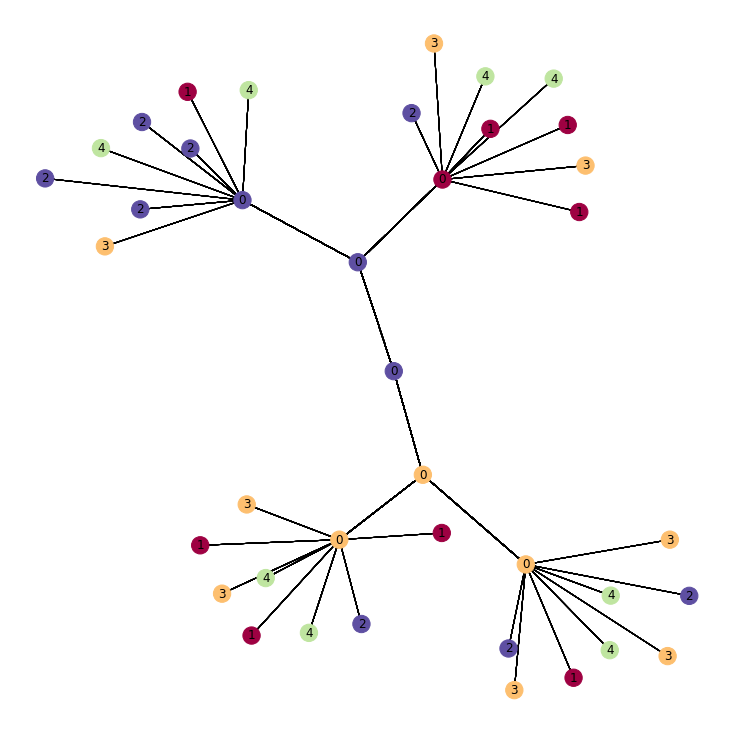

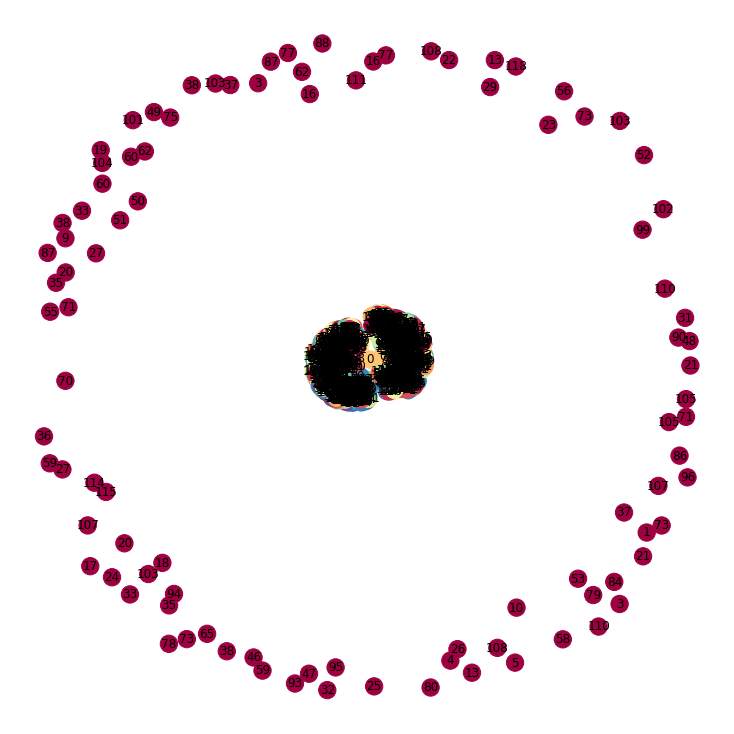

<module 'input' from '/home/anupa/Netmon/NetMon-query-planner/gurobi/input.py'>

In [42]:
import importlib
importlib.reload(input)

In [40]:
ov = get_overlay_from_perm(cb.best.x)
ov

[[37, 6, 23, 36, 21, 7, 29, 4],
 [19, 26, 32, 35, 27, 8, 34, 2],
 [30, 0, 33, 15, 10, 14, 16, 12],
 [22, 18, 28, 5, 9, 38, 1, 25, 20, 3, 31, 13, 24, 17, 11]]

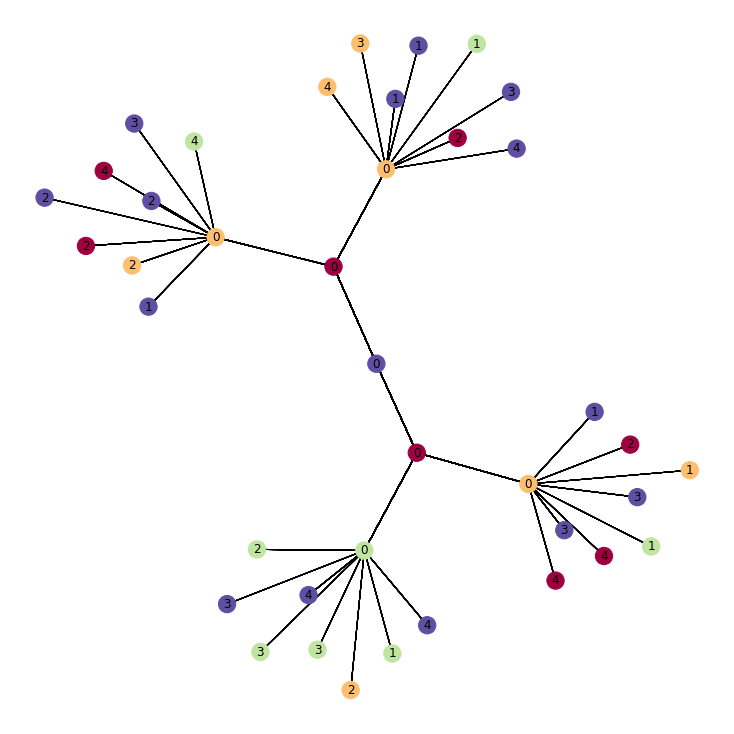

In [43]:
INP.overlay = ov
draw_overlay_over_tenant(INP)

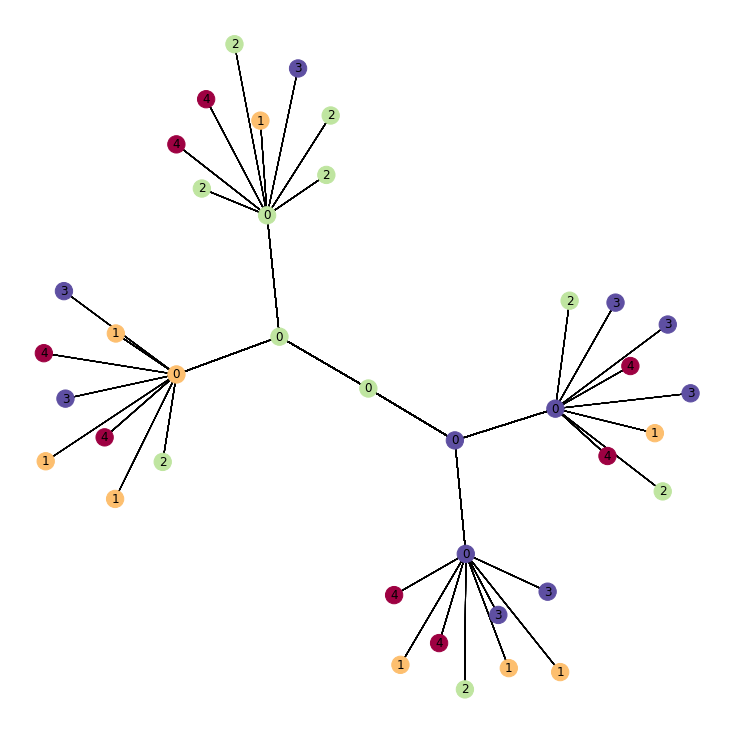

In [44]:
specA = dc_topology(hosts_per_tors=8, num_queries=4*40, tenant=True,
            overlay='spectralA', refine=True,
            queries_per_tenant=40)
draw_overlay_over_tenant(specA)

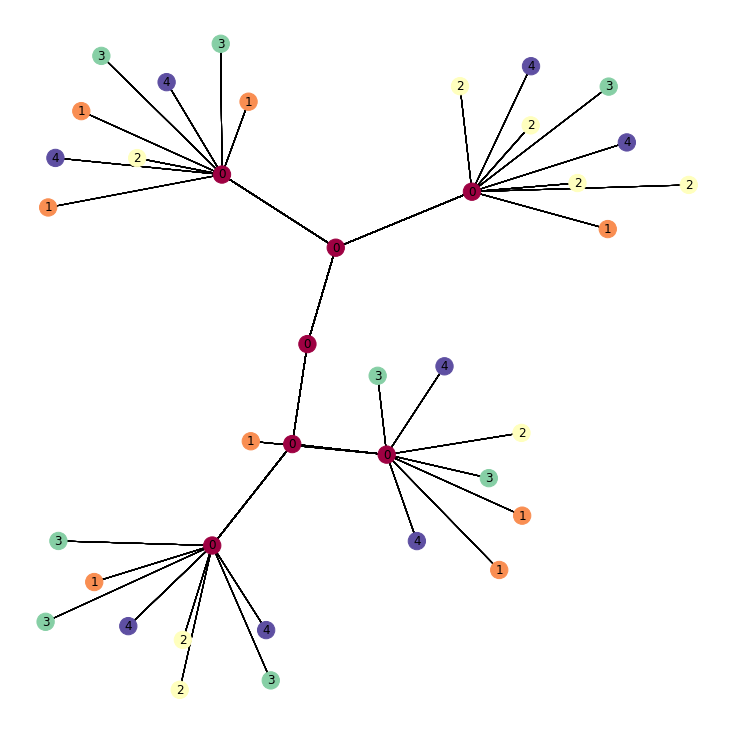

In [45]:
ten = dc_topology(hosts_per_tors=8, num_queries=4*40, tenant=True,
            overlay='tenant', refine=True,
            queries_per_tenant=40)
draw_overlay_over_tenant(ten)

In [46]:
cb.data.sort(key=lambda x: x[1])

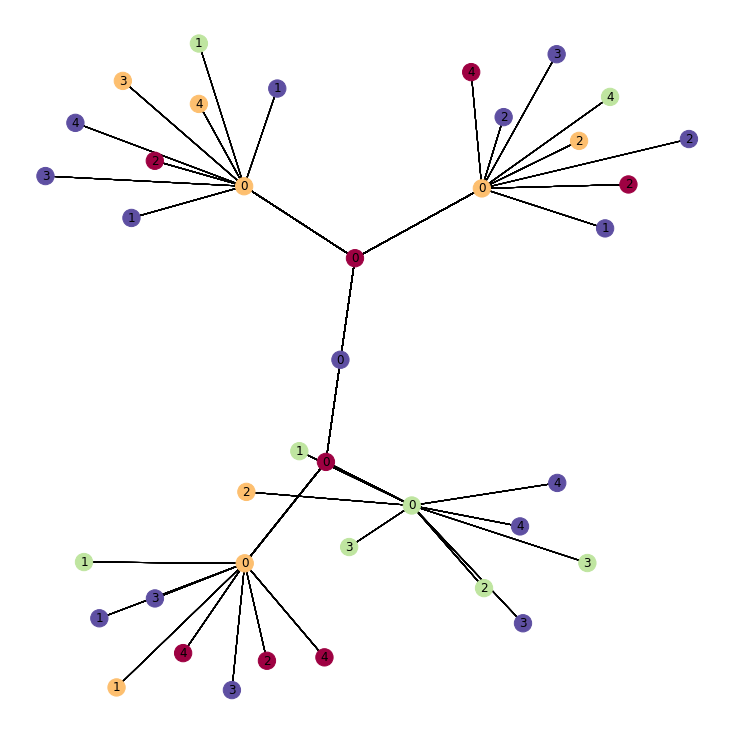

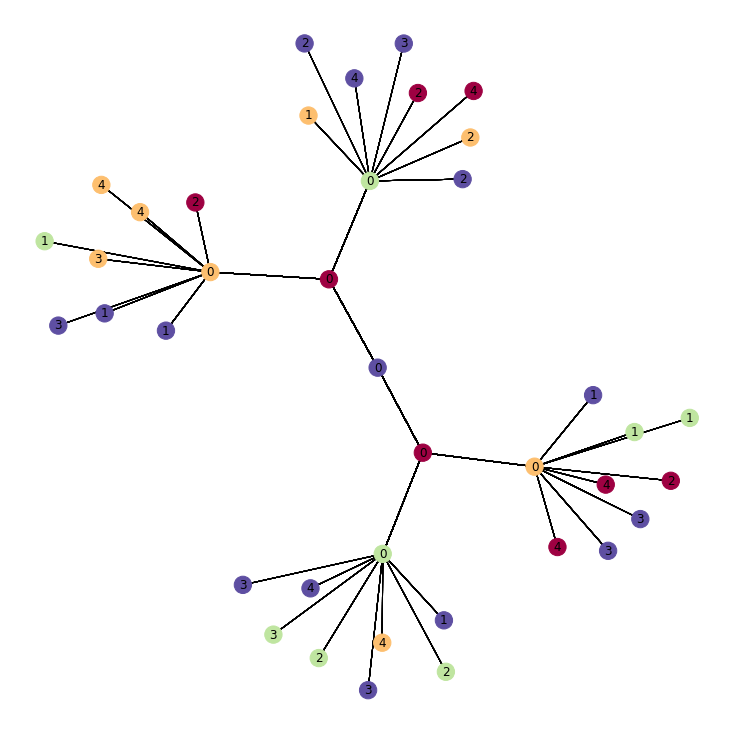

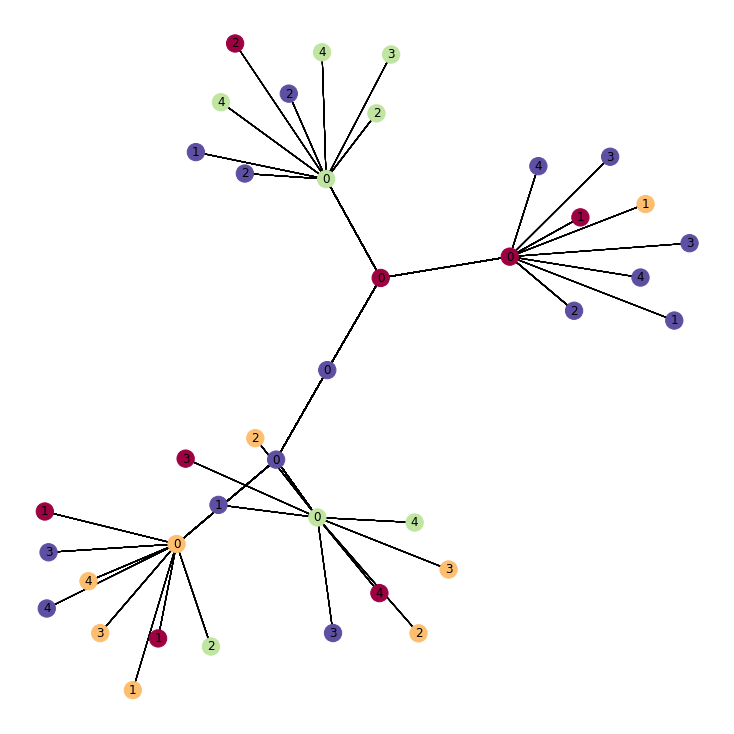

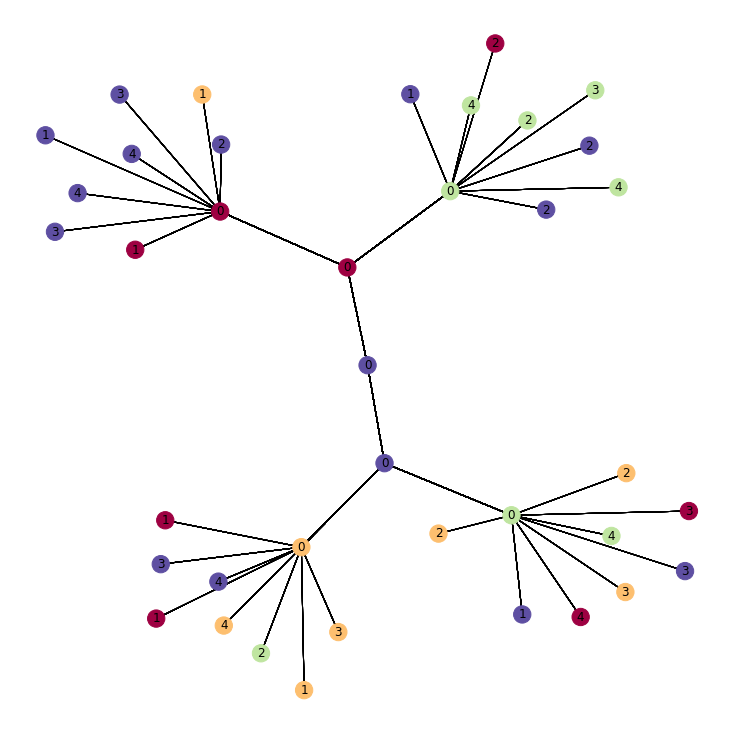

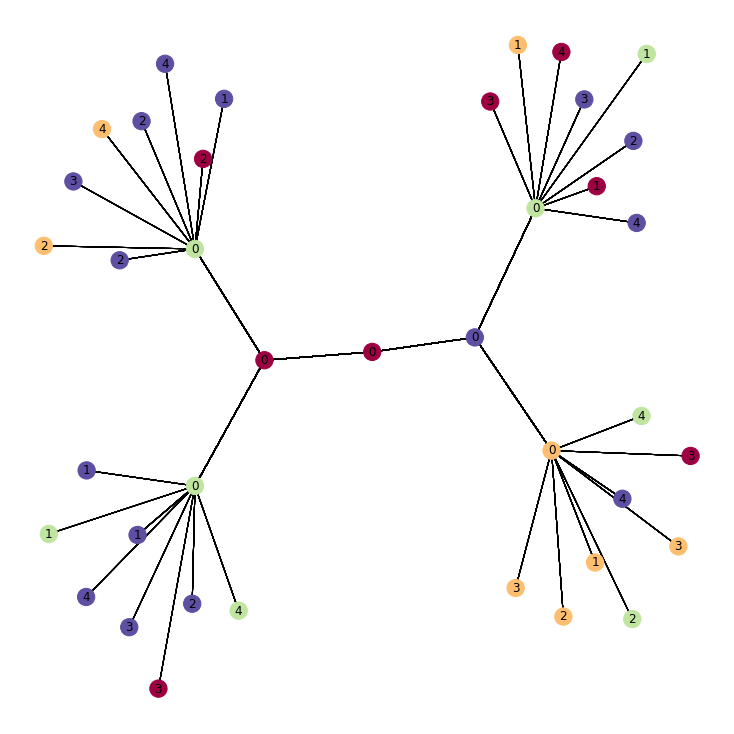

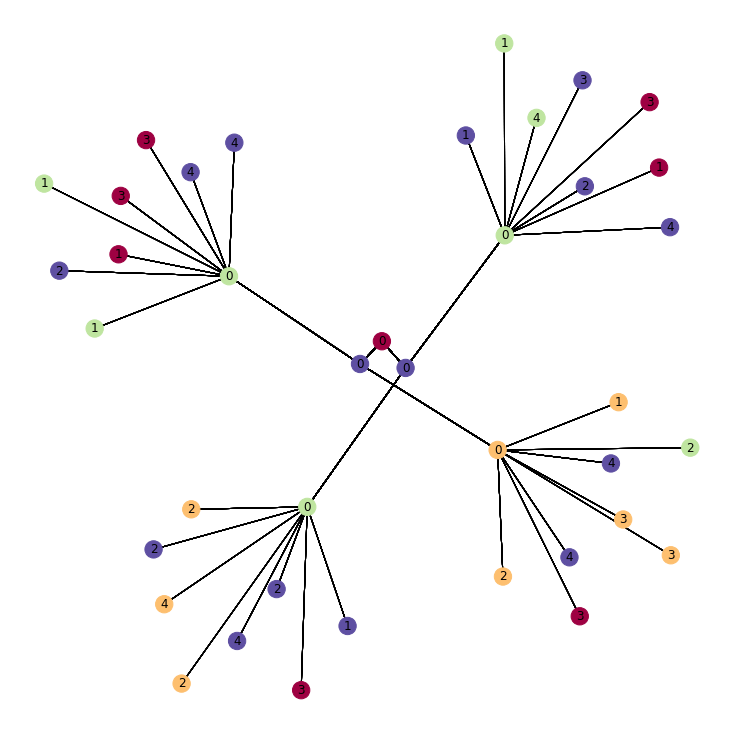

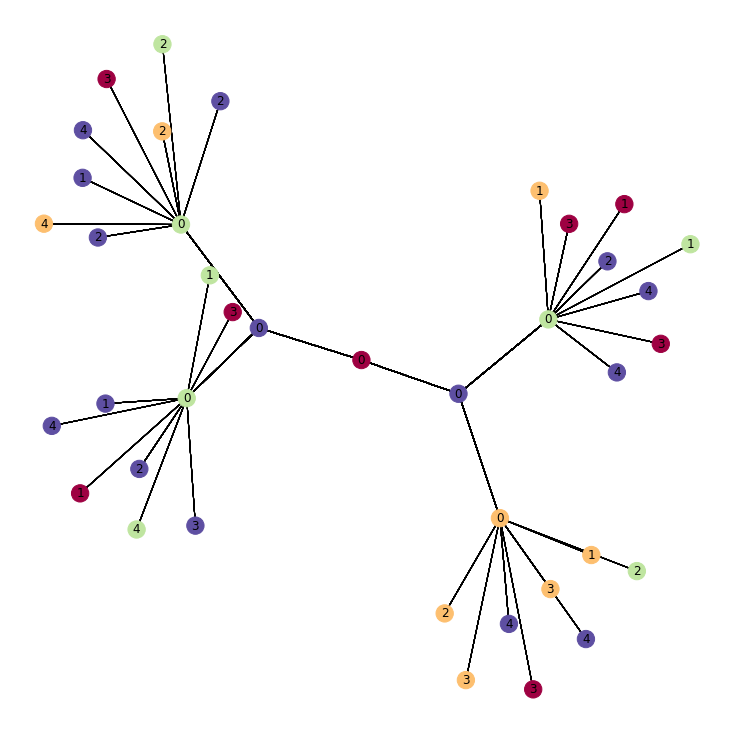

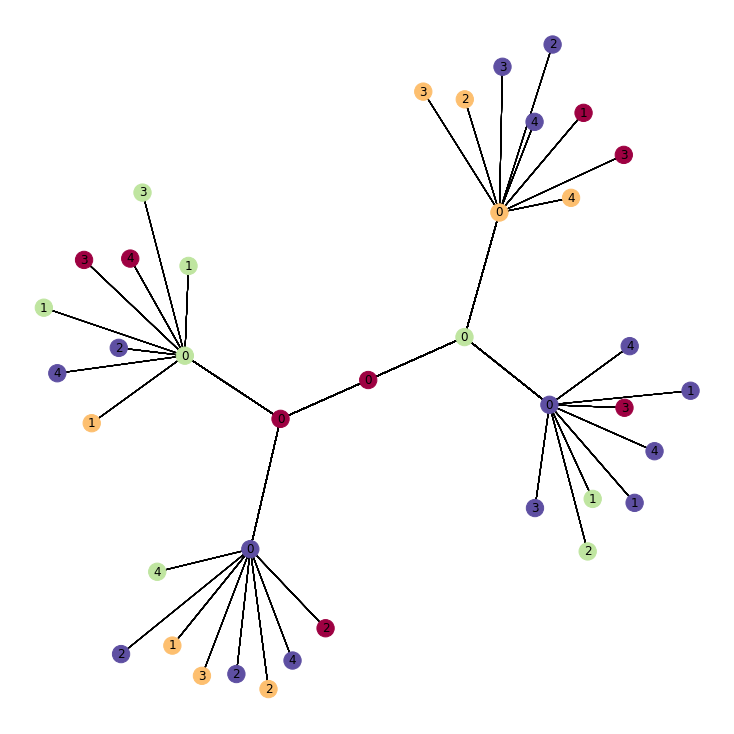

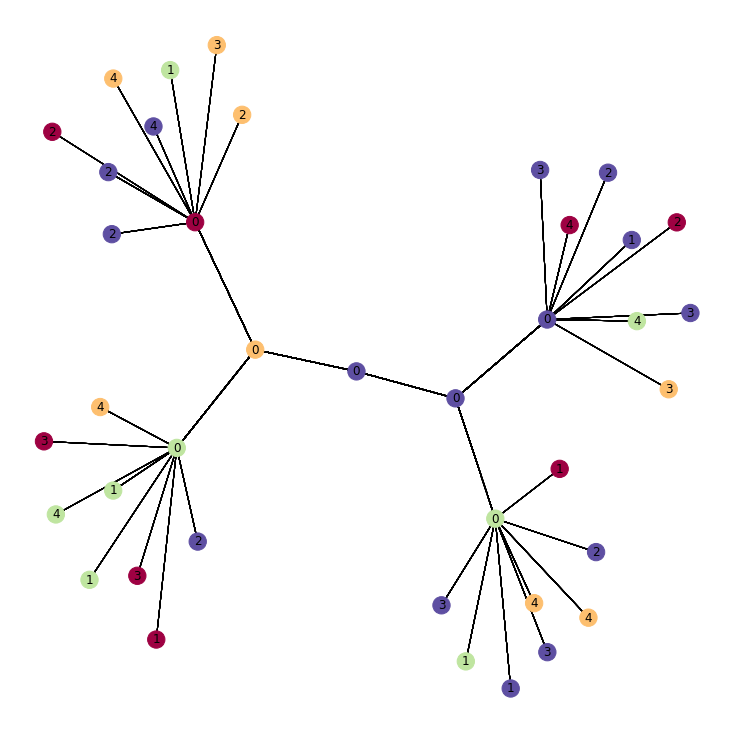

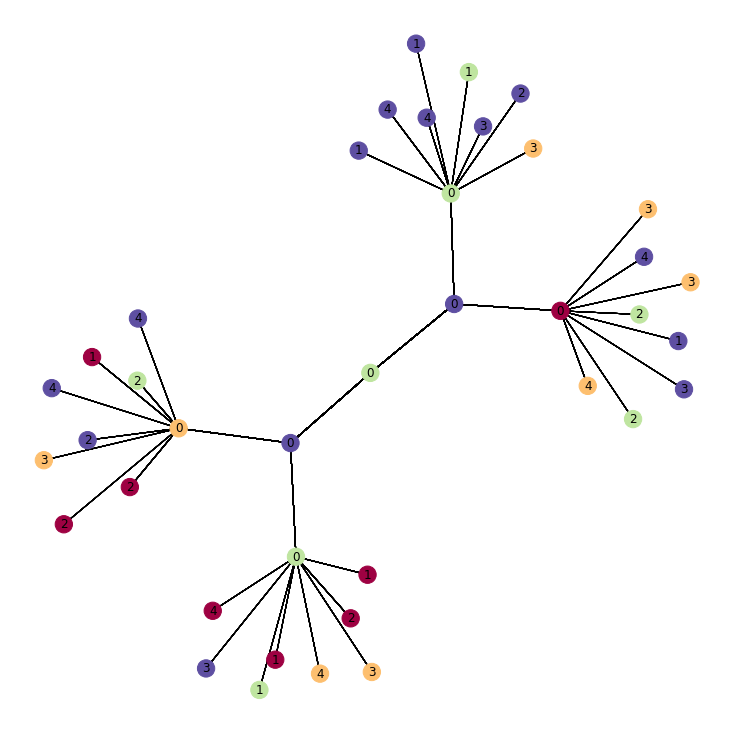

In [47]:
for i in range(10):
    ov = get_overlay_from_perm(cb.data[i][0])
    INP.overlay = ov
    draw_overlay_over_tenant(INP)

In [48]:
import pickle